In [1]:
import sys
# Find jVMC package
sys.path.append(sys.path[0] + "/..")

import jax
from jax.config import config
config.update("jax_enable_x64", True)

import jax.random as random
import jax.numpy as jnp
import flax.linen as nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/tmp/ipykernel_28794/3294815756.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# install the pip package and import jVMC
#!pip install jVMC

import jVMC

In [3]:
L = 10
g = -0.7

GPU_avail = False
# Initialize net
if GPU_avail:
  # reproduces results in Fig. 3 of the paper
  # estimated run_time in colab (GPU enabled): ~26 minutes
  net = jVMC.nets.CNN(F=(L,), channels=(16,), strides=(1,), periodicBoundary=True)
  n_steps = 1000
  n_Samples = 40000
else:
  # may be used to obtain results on Laptop CPUs
  # estimated run_time: ~100 seconds
  net = jVMC.nets.CpxRBM(numHidden=8, bias=False)
  n_steps = 300
  n_Samples = 5000

psi = jVMC.vqs.NQS(net, seed=1234)  # Variational wave function

In [4]:
def energy_single_p_mode(h_t, P):
    return np.sqrt(1 + h_t**2 - 2 * h_t * np.cos(P))

def ground_state_energy_per_site(h_t, N):
    Ps =  0.5 * np.arange(- (N - 1), N - 1 + 2, 2)
    Ps = Ps * 2 * np.pi / N
    energies_p_modes =  np.array([energy_single_p_mode(h_t, P) for P in Ps])
    return - 1 / N * np.sum(energies_p_modes)

exact_energy = ground_state_energy_per_site(g, L)
print(exact_energy)

-1.127222500154964


In [5]:
# Set up hamiltonian
hamiltonian = jVMC.operator.BranchFreeOperator()
for l in range(L):
    hamiltonian.add(jVMC.operator.scal_opstr(-1., (jVMC.operator.Sz(l), jVMC.operator.Sz((l + 1) % L))))
    hamiltonian.add(jVMC.operator.scal_opstr(g, (jVMC.operator.Sx(l), )))

In [6]:
# Set up sampler
sampler = jVMC.sampler.MCSampler(psi, (L,), random.PRNGKey(4321), updateProposer=jVMC.sampler.propose_spin_flip_Z2,
                                 numChains=100, sweepSteps=L,
                                 numSamples=n_Samples, thermalizationSweeps=25)

# Set up TDVP
tdvpEquation = jVMC.util.tdvp.TDVP(sampler, rhsPrefactor=1.,
                                   pinvTol=1e-8, diagonalShift=10, makeReal='real')

stepper = jVMC.util.stepper.Euler(timeStep=1e-2)  # ODE integrator

In [8]:
res = []
for n in tqdm(range(n_steps)):

    dp, _ = stepper.step(0, tdvpEquation, psi.get_parameters(), hamiltonian=hamiltonian, psi=psi, numSamples=None)
    psi.set_parameters(dp)

    print(n, jax.numpy.real(tdvpEquation.ElocMean0) / L, tdvpEquation.ElocVar0 / L)

    res.append([n, jax.numpy.real(tdvpEquation.ElocMean0) / L, tdvpEquation.ElocVar0 / L])

  0%|▏                                                                   | 1/300 [00:05<29:37,  5.94s/it]

0 -0.7052768720248059 0.9814466904811834


  1%|▍                                                                   | 2/300 [00:06<13:03,  2.63s/it]

1 -0.6980891907403228 1.0080792268621


  1%|▋                                                                   | 3/300 [00:06<07:44,  1.56s/it]

2 -0.7043580741951826 0.9561359867879154


  1%|▉                                                                   | 4/300 [00:06<05:13,  1.06s/it]

3 -0.7235262650437222 1.0132906668796287


  2%|█▏                                                                  | 5/300 [00:07<03:49,  1.28it/s]

4 -0.7179491323216888 0.9363914023666251


  2%|█▎                                                                  | 6/300 [00:07<03:00,  1.63it/s]

5 -0.71469937675695 0.9912287523706669


  2%|█▌                                                                  | 7/300 [00:07<02:29,  1.97it/s]

6 -0.721251932445075 0.9422641226732985


  3%|█▊                                                                  | 8/300 [00:08<02:11,  2.22it/s]

7 -0.7318413551508263 0.9967576335750621


  3%|██                                                                  | 9/300 [00:08<01:57,  2.48it/s]

8 -0.7293684810229604 0.9165517905740972


  3%|██▏                                                                | 10/300 [00:08<01:51,  2.59it/s]

9 -0.7331438668424954 0.9587522617080267


  4%|██▍                                                                | 11/300 [00:08<01:45,  2.75it/s]

10 -0.7367069322725242 0.9335812493501088


  4%|██▋                                                                | 12/300 [00:09<01:40,  2.86it/s]

11 -0.7449902249877287 0.9184897906982599


  4%|██▉                                                                | 13/300 [00:09<01:37,  2.95it/s]

12 -0.7412960919247198 0.9236477299605019


  5%|███▏                                                               | 14/300 [00:09<01:35,  2.99it/s]

13 -0.7529083311741324 0.9310997517416346


  5%|███▎                                                               | 15/300 [00:10<01:32,  3.07it/s]

14 -0.7473206872710313 0.9027018058385539


  5%|███▌                                                               | 16/300 [00:10<01:31,  3.10it/s]

15 -0.7588285571541309 0.8648828388158044


  6%|███▊                                                               | 17/300 [00:10<01:31,  3.10it/s]

16 -0.7639308866966322 0.8991584980640555


  6%|████                                                               | 18/300 [00:11<01:30,  3.12it/s]

17 -0.7748064523523734 0.8846504394686564


  6%|████▏                                                              | 19/300 [00:11<01:27,  3.20it/s]

18 -0.768101291600248 0.858772605671092


  7%|████▍                                                              | 20/300 [00:11<01:29,  3.11it/s]

19 -0.7710039683944946 0.877748358864013


  7%|████▋                                                              | 21/300 [00:12<01:28,  3.15it/s]

20 -0.7886522310196014 0.8931612044646713


  7%|████▉                                                              | 22/300 [00:12<01:26,  3.20it/s]

21 -0.7888032614424649 0.8764198490407982


  8%|█████▏                                                             | 23/300 [00:12<01:28,  3.14it/s]

22 -0.7836061499714415 0.8635509928918103


  8%|█████▎                                                             | 24/300 [00:13<01:30,  3.06it/s]

23 -0.7920520178516686 0.8488777935752955


  8%|█████▌                                                             | 25/300 [00:13<01:26,  3.17it/s]

24 -0.7894031918632578 0.8426063669242605


  9%|█████▊                                                             | 26/300 [00:13<01:24,  3.25it/s]

25 -0.7966169764827182 0.8326168354209104


  9%|██████                                                             | 27/300 [00:14<01:24,  3.22it/s]

26 -0.7984655693875171 0.8415513419827445


  9%|██████▎                                                            | 28/300 [00:14<01:24,  3.21it/s]

27 -0.8175344322232778 0.8190006360027147


 10%|██████▍                                                            | 29/300 [00:14<01:23,  3.26it/s]

28 -0.8066214102485105 0.8392816216876946


 10%|██████▋                                                            | 30/300 [00:14<01:21,  3.30it/s]

29 -0.8187374255649497 0.8289407787819141


 10%|██████▉                                                            | 31/300 [00:15<01:21,  3.30it/s]

30 -0.817060378652325 0.8268483647498609


 11%|███████▏                                                           | 32/300 [00:15<01:20,  3.33it/s]

31 -0.8266214553095763 0.8106245698732018


 11%|███████▎                                                           | 33/300 [00:15<01:19,  3.37it/s]

32 -0.8259339116827146 0.7888695293065229


 11%|███████▌                                                           | 34/300 [00:16<01:18,  3.39it/s]

33 -0.8378906476332706 0.801324358954923


 12%|███████▊                                                           | 35/300 [00:16<01:17,  3.42it/s]

34 -0.836420243766608 0.7743018921091004


 12%|████████                                                           | 36/300 [00:16<01:17,  3.40it/s]

35 -0.8409246859872288 0.7892425082446323


 12%|████████▎                                                          | 37/300 [00:16<01:17,  3.41it/s]

36 -0.8474029278332742 0.7759664449073854


 13%|████████▍                                                          | 38/300 [00:17<01:17,  3.39it/s]

37 -0.8595066110924285 0.7718648058500256


 13%|████████▋                                                          | 39/300 [00:17<01:18,  3.34it/s]

38 -0.8482745231030892 0.7664676035851968


 13%|████████▉                                                          | 40/300 [00:17<01:16,  3.39it/s]

39 -0.8636396890620601 0.7681632583484558


 14%|█████████▏                                                         | 41/300 [00:18<01:17,  3.36it/s]

40 -0.8703154531018418 0.7647342392827504


 14%|█████████▍                                                         | 42/300 [00:18<01:19,  3.25it/s]

41 -0.8696610203956305 0.7846982303092604


 14%|█████████▌                                                         | 43/300 [00:18<01:17,  3.32it/s]

42 -0.875528760427529 0.7587949154251585


 15%|█████████▊                                                         | 44/300 [00:19<01:16,  3.35it/s]

43 -0.8831645960133649 0.7322700834056353


 15%|██████████                                                         | 45/300 [00:19<01:18,  3.25it/s]

44 -0.8877232111327089 0.7128323570572713


 15%|██████████▎                                                        | 46/300 [00:19<01:22,  3.10it/s]

45 -0.8839936022863217 0.7566741912501458


 16%|██████████▍                                                        | 47/300 [00:20<01:23,  3.03it/s]

46 -0.8960201245657405 0.7167918596438975


 16%|██████████▋                                                        | 48/300 [00:20<01:30,  2.79it/s]

47 -0.898276925400561 0.7159093000482214


 16%|██████████▉                                                        | 49/300 [00:20<01:31,  2.73it/s]

48 -0.9028939817134354 0.7182544975039801


 17%|███████████▏                                                       | 50/300 [00:21<01:34,  2.64it/s]

49 -0.9087358394640781 0.678177200024267


 17%|███████████▍                                                       | 51/300 [00:21<01:33,  2.66it/s]

50 -0.9160925813909164 0.6820978627870428


 17%|███████████▌                                                       | 52/300 [00:22<01:33,  2.64it/s]

51 -0.9167336916823311 0.6751158176904197


 18%|███████████▊                                                       | 53/300 [00:22<01:37,  2.54it/s]

52 -0.9215931692431681 0.6637858004517835


 18%|████████████                                                       | 54/300 [00:22<01:41,  2.41it/s]

53 -0.9190731188107917 0.6734634324150515


 18%|████████████▎                                                      | 55/300 [00:23<01:41,  2.42it/s]

54 -0.9278029770827884 0.643676443275943


 19%|████████████▌                                                      | 56/300 [00:23<01:35,  2.55it/s]

55 -0.9418787278357641 0.6517971818231793


 19%|████████████▋                                                      | 57/300 [00:24<01:45,  2.30it/s]

56 -0.933125075957433 0.6459448142211048


 19%|████████████▉                                                      | 58/300 [00:24<01:41,  2.38it/s]

57 -0.9430508324957898 0.623187963571417


 20%|█████████████▏                                                     | 59/300 [00:25<01:40,  2.39it/s]

58 -0.9474826610683269 0.5975872181632791


 20%|█████████████▍                                                     | 60/300 [00:25<01:41,  2.37it/s]

59 -0.94948145586061 0.6159653134521361


 20%|█████████████▌                                                     | 61/300 [00:25<01:37,  2.45it/s]

60 -0.9565358658231938 0.6138595907411648


 21%|█████████████▊                                                     | 62/300 [00:26<01:38,  2.41it/s]

61 -0.9594403753492429 0.58354448957836


 21%|██████████████                                                     | 63/300 [00:26<01:37,  2.42it/s]

62 -0.9687865116709069 0.5840371524580427


 21%|██████████████▎                                                    | 64/300 [00:27<01:38,  2.40it/s]

63 -0.9771805286539671 0.5731130987127215


 22%|██████████████▌                                                    | 65/300 [00:27<01:38,  2.39it/s]

64 -0.9796636181677485 0.5379073731893382


 22%|██████████████▋                                                    | 66/300 [00:28<01:40,  2.33it/s]

65 -0.981615348806991 0.5482006684420683


 22%|██████████████▉                                                    | 67/300 [00:28<01:41,  2.30it/s]

66 -0.9864250455227197 0.5306011332503343


 23%|███████████████▏                                                   | 68/300 [00:28<01:46,  2.18it/s]

67 -0.9838816356977066 0.5250410484255543


 23%|███████████████▍                                                   | 69/300 [00:29<01:37,  2.37it/s]

68 -0.9945654559443404 0.5111375416563338


 23%|███████████████▋                                                   | 70/300 [00:29<01:31,  2.51it/s]

69 -0.9964704609688797 0.5075772354143883


 24%|███████████████▊                                                   | 71/300 [00:30<01:30,  2.52it/s]

70 -0.994272307742871 0.5140357884089273


 24%|████████████████                                                   | 72/300 [00:30<01:27,  2.61it/s]

71 -1.0031862472965747 0.48764265342109675


 24%|████████████████▎                                                  | 73/300 [00:30<01:24,  2.70it/s]

72 -1.0143551848666787 0.4530412078646343


 25%|████████████████▌                                                  | 74/300 [00:31<01:22,  2.74it/s]

73 -1.0096666447765281 0.456687781846503


 25%|████████████████▊                                                  | 75/300 [00:31<01:21,  2.75it/s]

74 -1.013017946777213 0.45521449953567544


 25%|████████████████▉                                                  | 76/300 [00:31<01:20,  2.79it/s]

75 -1.0151348406698282 0.45338944464527514


 26%|█████████████████▏                                                 | 77/300 [00:32<01:18,  2.82it/s]

76 -1.0215104673913373 0.43959471375192705


 26%|█████████████████▍                                                 | 78/300 [00:32<01:20,  2.77it/s]

77 -1.0228033388828757 0.4220089650290581


 26%|█████████████████▋                                                 | 79/300 [00:32<01:22,  2.68it/s]

78 -1.0320451043674757 0.40899202524113926


 27%|█████████████████▊                                                 | 80/300 [00:33<01:25,  2.58it/s]

79 -1.0345953523771672 0.39812432013238974


 27%|██████████████████                                                 | 81/300 [00:33<01:26,  2.54it/s]

80 -1.0337158723318698 0.3995539314596836


 27%|██████████████████▎                                                | 82/300 [00:34<01:21,  2.66it/s]

81 -1.0430410971927229 0.36633048377167066


 28%|██████████████████▌                                                | 83/300 [00:34<01:20,  2.71it/s]

82 -1.0433016823817696 0.36884778957169095


 28%|██████████████████▊                                                | 84/300 [00:34<01:18,  2.75it/s]

83 -1.0410038338831253 0.38357629999359893


 28%|██████████████████▉                                                | 85/300 [00:35<01:19,  2.69it/s]

84 -1.053063793449541 0.33480672912435716


 29%|███████████████████▏                                               | 86/300 [00:35<01:18,  2.73it/s]

85 -1.054565140019887 0.3316372785554106


 29%|███████████████████▍                                               | 87/300 [00:35<01:16,  2.78it/s]

86 -1.0529502356358247 0.31906539527380157


 29%|███████████████████▋                                               | 88/300 [00:36<01:19,  2.66it/s]

87 -1.0575596042038469 0.31730567790488523


 30%|███████████████████▉                                               | 89/300 [00:36<01:17,  2.71it/s]

88 -1.0558478599539671 0.31832655701273666


 30%|████████████████████                                               | 90/300 [00:37<01:19,  2.66it/s]

89 -1.0638002999208904 0.2975594069942764


 30%|████████████████████▎                                              | 91/300 [00:37<01:16,  2.75it/s]

90 -1.0642097744338037 0.2921239316417238


 31%|████████████████████▌                                              | 92/300 [00:37<01:15,  2.76it/s]

91 -1.0706170898770022 0.2677262959511032


 31%|████████████████████▊                                              | 93/300 [00:38<01:17,  2.67it/s]

92 -1.0708582420895527 0.2620045183981764


 31%|████████████████████▉                                              | 94/300 [00:38<01:15,  2.72it/s]

93 -1.070597694671557 0.25924001391518847


 32%|█████████████████████▏                                             | 95/300 [00:38<01:13,  2.78it/s]

94 -1.0733417167955357 0.2433765632933489


 32%|█████████████████████▍                                             | 96/300 [00:39<01:14,  2.75it/s]

95 -1.0730559362483176 0.24118139824307788


 32%|█████████████████████▋                                             | 97/300 [00:39<01:12,  2.82it/s]

96 -1.081087016071547 0.23112739165211854


 33%|█████████████████████▉                                             | 98/300 [00:39<01:10,  2.85it/s]

97 -1.0803251819456898 0.2206238450974196


 33%|██████████████████████                                             | 99/300 [00:40<01:11,  2.83it/s]

98 -1.0753497334244106 0.23622702547710178


 33%|██████████████████████                                            | 100/300 [00:40<01:11,  2.81it/s]

99 -1.0815854763284203 0.2230538563331475


 34%|██████████████████████▏                                           | 101/300 [00:40<01:10,  2.82it/s]

100 -1.0803989536807113 0.21195894725372347


 34%|██████████████████████▍                                           | 102/300 [00:41<01:09,  2.85it/s]

101 -1.0842590553804297 0.20991721947284772


 34%|██████████████████████▋                                           | 103/300 [00:41<01:09,  2.84it/s]

102 -1.0899653295085927 0.19768979958506994


 35%|██████████████████████▉                                           | 104/300 [00:42<01:09,  2.81it/s]

103 -1.0877796271191622 0.18692089499971037


 35%|███████████████████████                                           | 105/300 [00:42<01:08,  2.86it/s]

104 -1.092349305721957 0.1768462492586106


 35%|███████████████████████▎                                          | 106/300 [00:42<01:08,  2.82it/s]

105 -1.0884503666121133 0.1897836415208053


 36%|███████████████████████▌                                          | 107/300 [00:43<01:07,  2.85it/s]

106 -1.0908888211454089 0.1812395584636506


 36%|███████████████████████▊                                          | 108/300 [00:43<01:06,  2.89it/s]

107 -1.0905644843273663 0.17300845080488977


 36%|███████████████████████▉                                          | 109/300 [00:43<01:06,  2.86it/s]

108 -1.0940429630976811 0.16028446444912975


 37%|████████████████████████▏                                         | 110/300 [00:44<01:05,  2.90it/s]

109 -1.0992672557287062 0.1408161235588981


 37%|████████████████████████▍                                         | 111/300 [00:44<01:05,  2.90it/s]

110 -1.1000095526196498 0.14343604108107746


 37%|████████████████████████▋                                         | 112/300 [00:44<01:04,  2.90it/s]

111 -1.094533049045483 0.15163602266190662


 38%|████████████████████████▊                                         | 113/300 [00:45<01:06,  2.81it/s]

112 -1.0962325583327361 0.15840093223960364


 38%|█████████████████████████                                         | 114/300 [00:45<01:05,  2.84it/s]

113 -1.0966190132231217 0.1579841358006064


 38%|█████████████████████████▎                                        | 115/300 [00:45<01:04,  2.85it/s]

114 -1.1021160268738972 0.13927680675784274


 39%|█████████████████████████▌                                        | 116/300 [00:46<01:03,  2.88it/s]

115 -1.1026318824165515 0.13223724356747535


 39%|█████████████████████████▋                                        | 117/300 [00:46<01:03,  2.88it/s]

116 -1.101207972107819 0.1305897402801304


 39%|█████████████████████████▉                                        | 118/300 [00:46<01:03,  2.87it/s]

117 -1.1018930721803104 0.12335401848690941


 40%|██████████████████████████▏                                       | 119/300 [00:47<01:02,  2.89it/s]

118 -1.1039198255150793 0.11872717297017883


 40%|██████████████████████████▍                                       | 120/300 [00:47<01:07,  2.69it/s]

119 -1.1074770687682212 0.11012792090339985


 40%|██████████████████████████▌                                       | 121/300 [00:47<01:04,  2.76it/s]

120 -1.0996323389382112 0.13176194739037422


 41%|██████████████████████████▊                                       | 122/300 [00:48<01:03,  2.80it/s]

121 -1.1071461938267946 0.10583450188252475


 41%|███████████████████████████                                       | 123/300 [00:48<01:03,  2.81it/s]

122 -1.108514652132289 0.0981558844577485


 41%|███████████████████████████▎                                      | 124/300 [00:49<01:01,  2.86it/s]

123 -1.1096395779076613 0.09143372548480885


 42%|███████████████████████████▌                                      | 125/300 [00:49<01:09,  2.52it/s]

124 -1.1072901421887715 0.10019414844953863


 42%|███████████████████████████▋                                      | 126/300 [00:49<01:07,  2.57it/s]

125 -1.110687953752853 0.0910493779790794


 42%|███████████████████████████▉                                      | 127/300 [00:50<01:05,  2.66it/s]

126 -1.1104229953874374 0.0905606882394182


 43%|████████████████████████████▏                                     | 128/300 [00:50<01:03,  2.69it/s]

127 -1.1112471201093785 0.08934997794034469


 43%|████████████████████████████▍                                     | 129/300 [00:50<01:04,  2.67it/s]

128 -1.1148897146404906 0.07144819249299823


 43%|████████████████████████████▌                                     | 130/300 [00:51<01:01,  2.77it/s]

129 -1.1132993622173841 0.08513973361537397


 44%|████████████████████████████▊                                     | 131/300 [00:51<01:00,  2.79it/s]

130 -1.1097549429183329 0.08634942520299115


 44%|█████████████████████████████                                     | 132/300 [00:52<01:00,  2.77it/s]

131 -1.1154810486369 0.07316400083594088


 44%|█████████████████████████████▎                                    | 133/300 [00:52<01:02,  2.68it/s]

132 -1.1119882832349393 0.08068582052092522


 45%|█████████████████████████████▍                                    | 134/300 [00:52<01:00,  2.77it/s]

133 -1.1127936737689028 0.07179074371409742


 45%|█████████████████████████████▋                                    | 135/300 [00:53<01:00,  2.72it/s]

134 -1.1162747247569347 0.06746957440299883


 45%|█████████████████████████████▉                                    | 136/300 [00:53<01:00,  2.70it/s]

135 -1.1119415012184448 0.0833638018453418


 46%|██████████████████████████████▏                                   | 137/300 [00:53<01:00,  2.71it/s]

136 -1.1144727865170956 0.06139175466795791


 46%|██████████████████████████████▎                                   | 138/300 [00:54<00:58,  2.76it/s]

137 -1.1129330081529138 0.07505256135881029


 46%|██████████████████████████████▌                                   | 139/300 [00:54<00:58,  2.75it/s]

138 -1.115656004495676 0.07093354289583129


 47%|██████████████████████████████▊                                   | 140/300 [00:54<00:56,  2.85it/s]

139 -1.1173748522345945 0.0636623374255286


 47%|███████████████████████████████                                   | 141/300 [00:55<00:55,  2.88it/s]

140 -1.1174167038137728 0.06537087061483093


 47%|███████████████████████████████▏                                  | 142/300 [00:55<00:54,  2.92it/s]

141 -1.1196823135662206 0.05311032445733125


 48%|███████████████████████████████▍                                  | 143/300 [00:55<00:54,  2.89it/s]

142 -1.1168958001280571 0.05990169706781059


 48%|███████████████████████████████▋                                  | 144/300 [00:56<00:54,  2.87it/s]

143 -1.1187930045003118 0.05527590555808674


 48%|███████████████████████████████▉                                  | 145/300 [00:56<00:54,  2.86it/s]

144 -1.1189958571406495 0.0540687096125169


 49%|████████████████████████████████                                  | 146/300 [00:57<00:54,  2.85it/s]

145 -1.1186586536533776 0.05455564411951712


 49%|████████████████████████████████▎                                 | 147/300 [00:57<00:54,  2.82it/s]

146 -1.1171464521645837 0.057989905764584834


 49%|████████████████████████████████▌                                 | 148/300 [00:57<00:54,  2.80it/s]

147 -1.1202963684035685 0.04475209871123711


 50%|████████████████████████████████▊                                 | 149/300 [00:58<00:52,  2.85it/s]

148 -1.120260766172952 0.04875490823457089


 50%|█████████████████████████████████                                 | 150/300 [00:58<00:58,  2.57it/s]

149 -1.1201592261620532 0.047987512124370295


 50%|█████████████████████████████████▏                                | 151/300 [00:58<00:56,  2.61it/s]

150 -1.1197853038322394 0.04349254697413727


 51%|█████████████████████████████████▍                                | 152/300 [00:59<00:56,  2.61it/s]

151 -1.120212893489308 0.04299814448337924


 51%|█████████████████████████████████▋                                | 153/300 [00:59<00:57,  2.57it/s]

152 -1.120294788892116 0.04065858571925894


 51%|█████████████████████████████████▉                                | 154/300 [01:00<00:59,  2.47it/s]

153 -1.1191548428799698 0.0425328036382028


 52%|██████████████████████████████████                                | 155/300 [01:00<00:57,  2.54it/s]

154 -1.1182991220621337 0.04758853400561909


 52%|██████████████████████████████████▎                               | 156/300 [01:00<00:55,  2.59it/s]

155 -1.1204743507585004 0.039262721399986183


 52%|██████████████████████████████████▌                               | 157/300 [01:01<00:57,  2.50it/s]

156 -1.1187237863749249 0.0453455303825918


 53%|██████████████████████████████████▊                               | 158/300 [01:01<00:53,  2.64it/s]

157 -1.1193013432222187 0.03894679447821044


 53%|██████████████████████████████████▉                               | 159/300 [01:02<00:52,  2.71it/s]

158 -1.1202002983786465 0.04211489729239008


 53%|███████████████████████████████████▏                              | 160/300 [01:02<00:51,  2.71it/s]

159 -1.11969118946931 0.044776822187268334


 54%|███████████████████████████████████▍                              | 161/300 [01:02<00:51,  2.72it/s]

160 -1.1205837524036153 0.03900228792524747


 54%|███████████████████████████████████▋                              | 162/300 [01:03<00:49,  2.76it/s]

161 -1.1207216524000452 0.03747128543734783


 54%|███████████████████████████████████▊                              | 163/300 [01:03<00:49,  2.75it/s]

162 -1.122206947938015 0.031234096098497154


 55%|████████████████████████████████████                              | 164/300 [01:03<00:49,  2.76it/s]

163 -1.1217921397828081 0.03890306367148903


 55%|████████████████████████████████████▎                             | 165/300 [01:04<00:48,  2.80it/s]

164 -1.1208838623629833 0.033785086465940674


 55%|████████████████████████████████████▌                             | 166/300 [01:04<00:47,  2.83it/s]

165 -1.122091447512855 0.030567794755621734


 56%|████████████████████████████████████▋                             | 167/300 [01:04<00:45,  2.90it/s]

166 -1.121399340101242 0.034622957433931394


 56%|████████████████████████████████████▉                             | 168/300 [01:05<00:45,  2.90it/s]

167 -1.1209124467687954 0.031757922225106455


 56%|█████████████████████████████████████▏                            | 169/300 [01:05<00:45,  2.90it/s]

168 -1.1211066401152574 0.03611322836834779


 57%|█████████████████████████████████████▍                            | 170/300 [01:05<00:44,  2.90it/s]

169 -1.1200803789663298 0.03599803803325808


 57%|█████████████████████████████████████▌                            | 171/300 [01:06<00:44,  2.88it/s]

170 -1.1226173460659268 0.030215009330050946


 57%|█████████████████████████████████████▊                            | 172/300 [01:06<00:44,  2.89it/s]

171 -1.1204248163938906 0.03421944198681635


 58%|██████████████████████████████████████                            | 173/300 [01:06<00:43,  2.90it/s]

172 -1.1210767583961623 0.03265105588504128


 58%|██████████████████████████████████████▎                           | 174/300 [01:07<00:43,  2.88it/s]

173 -1.1214285201313705 0.03438153484942671


 58%|██████████████████████████████████████▌                           | 175/300 [01:07<00:43,  2.89it/s]

174 -1.1207823892976014 0.0349499595652079


 59%|██████████████████████████████████████▋                           | 176/300 [01:07<00:42,  2.88it/s]

175 -1.1214226507940428 0.03464453223413285


 59%|██████████████████████████████████████▉                           | 177/300 [01:08<00:42,  2.88it/s]

176 -1.1214216558121382 0.030834676949940458


 59%|███████████████████████████████████████▏                          | 178/300 [01:08<00:42,  2.88it/s]

177 -1.1219295995263165 0.02536575972600281


 60%|███████████████████████████████████████▍                          | 179/300 [01:08<00:41,  2.90it/s]

178 -1.1218216056326988 0.03294953541618449


 60%|███████████████████████████████████████▌                          | 180/300 [01:09<00:40,  2.94it/s]

179 -1.122733930238213 0.02944280344645714


 60%|███████████████████████████████████████▊                          | 181/300 [01:09<00:40,  2.94it/s]

180 -1.122419893239239 0.030844534667653467


 61%|████████████████████████████████████████                          | 182/300 [01:09<00:39,  2.95it/s]

181 -1.122768038380758 0.02947985855250036


 61%|████████████████████████████████████████▎                         | 183/300 [01:10<00:39,  2.95it/s]

182 -1.122183120576239 0.02873179488981418


 61%|████████████████████████████████████████▍                         | 184/300 [01:10<00:40,  2.87it/s]

183 -1.121583743455182 0.030256654136187083


 62%|████████████████████████████████████████▋                         | 185/300 [01:11<00:39,  2.90it/s]

184 -1.1229674092785624 0.023719372386048623


 62%|████████████████████████████████████████▉                         | 186/300 [01:11<00:38,  2.93it/s]

185 -1.1214587508966893 0.0273839735315309


 62%|█████████████████████████████████████████▏                        | 187/300 [01:11<00:39,  2.89it/s]

186 -1.1236250093501658 0.02358737949818248


 63%|█████████████████████████████████████████▎                        | 188/300 [01:12<00:40,  2.79it/s]

187 -1.1223893628743127 0.026406349621386754


 63%|█████████████████████████████████████████▌                        | 189/300 [01:12<00:38,  2.87it/s]

188 -1.1237907939259386 0.022838126955362543


 63%|█████████████████████████████████████████▊                        | 190/300 [01:12<00:37,  2.90it/s]

189 -1.1224247459917316 0.02869739878930213


 64%|██████████████████████████████████████████                        | 191/300 [01:13<00:38,  2.86it/s]

190 -1.1229729873950487 0.0236298165966116


 64%|██████████████████████████████████████████▏                       | 192/300 [01:13<00:37,  2.85it/s]

191 -1.1222451434827811 0.025913636336337163


 64%|██████████████████████████████████████████▍                       | 193/300 [01:13<00:38,  2.75it/s]

192 -1.1219875509207655 0.029395224832041218


 65%|██████████████████████████████████████████▋                       | 194/300 [01:14<00:37,  2.83it/s]

193 -1.1230188505556846 0.026013498107476697


 65%|██████████████████████████████████████████▉                       | 195/300 [01:14<00:37,  2.81it/s]

194 -1.1232708750064437 0.025655129542231668


 65%|███████████████████████████████████████████                       | 196/300 [01:14<00:36,  2.87it/s]

195 -1.1227476819853908 0.025337226531661084


 66%|███████████████████████████████████████████▎                      | 197/300 [01:15<00:36,  2.85it/s]

196 -1.1232832360234988 0.02276901348091267


 66%|███████████████████████████████████████████▌                      | 198/300 [01:15<00:35,  2.87it/s]

197 -1.1224981800924465 0.02185641997808943


 66%|███████████████████████████████████████████▊                      | 199/300 [01:15<00:35,  2.86it/s]

198 -1.122346742193097 0.02513130983574694


 67%|████████████████████████████████████████████                      | 200/300 [01:16<00:34,  2.88it/s]

199 -1.1215041669843386 0.022737364686853886


 67%|████████████████████████████████████████████▏                     | 201/300 [01:16<00:34,  2.90it/s]

200 -1.123897945999598 0.02322579313254471


 67%|████████████████████████████████████████████▍                     | 202/300 [01:16<00:34,  2.88it/s]

201 -1.1246297042075224 0.019646044010233742


 68%|████████████████████████████████████████████▋                     | 203/300 [01:17<00:33,  2.86it/s]

202 -1.123544900404593 0.017731674602416526


 68%|████████████████████████████████████████████▉                     | 204/300 [01:17<00:33,  2.88it/s]

203 -1.1237043858800824 0.027216665002959058


 68%|█████████████████████████████████████████████                     | 205/300 [01:18<00:32,  2.88it/s]

204 -1.1228227579145127 0.02722130741368033


 69%|█████████████████████████████████████████████▎                    | 206/300 [01:18<00:32,  2.90it/s]

205 -1.1234927028281843 0.019955527231072263


 69%|█████████████████████████████████████████████▌                    | 207/300 [01:18<00:32,  2.91it/s]

206 -1.1230439622966677 0.02508970029568678


 69%|█████████████████████████████████████████████▊                    | 208/300 [01:19<00:32,  2.87it/s]

207 -1.123276301131304 0.0238489161505274


 70%|█████████████████████████████████████████████▉                    | 209/300 [01:19<00:31,  2.92it/s]

208 -1.1231653334476752 0.02562015196949092


 70%|██████████████████████████████████████████████▏                   | 210/300 [01:19<00:30,  2.91it/s]

209 -1.1224072984051117 0.021856170969030135


 70%|██████████████████████████████████████████████▍                   | 211/300 [01:20<00:30,  2.94it/s]

210 -1.123873771329618 0.027697459259314678


 71%|██████████████████████████████████████████████▋                   | 212/300 [01:20<00:30,  2.90it/s]

211 -1.1241598517814615 0.022200150121819782


 71%|██████████████████████████████████████████████▊                   | 213/300 [01:20<00:30,  2.85it/s]

212 -1.122703682104857 0.023306002369879196


 71%|███████████████████████████████████████████████                   | 214/300 [01:21<00:30,  2.82it/s]

213 -1.1246025020507004 0.018009600969397258


 72%|███████████████████████████████████████████████▎                  | 215/300 [01:21<00:29,  2.85it/s]

214 -1.123704587594456 0.02147340569443055


 72%|███████████████████████████████████████████████▌                  | 216/300 [01:21<00:29,  2.86it/s]

215 -1.1231587566633003 0.025363746416073703


 72%|███████████████████████████████████████████████▋                  | 217/300 [01:22<00:28,  2.91it/s]

216 -1.1239870157445864 0.022538774640504456


 73%|███████████████████████████████████████████████▉                  | 218/300 [01:22<00:27,  2.95it/s]

217 -1.1235236248214149 0.022401251481463623


 73%|████████████████████████████████████████████████▏                 | 219/300 [01:22<00:28,  2.87it/s]

218 -1.1235471766591572 0.01755109075283847


 73%|████████████████████████████████████████████████▍                 | 220/300 [01:23<00:27,  2.88it/s]

219 -1.1239545041726537 0.021476629022674498


 74%|████████████████████████████████████████████████▌                 | 221/300 [01:23<00:26,  2.95it/s]

220 -1.1229071548393448 0.020193131583164107


 74%|████████████████████████████████████████████████▊                 | 222/300 [01:23<00:26,  2.95it/s]

221 -1.1241505862836934 0.01992139599232966


 74%|█████████████████████████████████████████████████                 | 223/300 [01:24<00:26,  2.94it/s]

222 -1.1228846159559156 0.020395565860934568


 75%|█████████████████████████████████████████████████▎                | 224/300 [01:24<00:25,  2.98it/s]

223 -1.122289029244046 0.023865510151703313


 75%|█████████████████████████████████████████████████▌                | 225/300 [01:24<00:26,  2.87it/s]

224 -1.12279777287289 0.026768318886730792


 75%|█████████████████████████████████████████████████▋                | 226/300 [01:25<00:26,  2.83it/s]

225 -1.1235857118869035 0.020473462192659397


 76%|█████████████████████████████████████████████████▉                | 227/300 [01:25<00:25,  2.84it/s]

226 -1.1228635085300556 0.01995359516689329


 76%|██████████████████████████████████████████████████▏               | 228/300 [01:26<00:25,  2.79it/s]

227 -1.1234913454558169 0.01798651093977253


 76%|██████████████████████████████████████████████████▍               | 229/300 [01:26<00:25,  2.83it/s]

228 -1.1242236117406041 0.018635551311106925


 77%|██████████████████████████████████████████████████▌               | 230/300 [01:26<00:24,  2.85it/s]

229 -1.1230169147221292 0.020731167844280245


 77%|██████████████████████████████████████████████████▊               | 231/300 [01:27<00:23,  2.90it/s]

230 -1.1223559153593923 0.022662140722646527


 77%|███████████████████████████████████████████████████               | 232/300 [01:27<00:24,  2.80it/s]

231 -1.1240214362961305 0.02045171671501016


 78%|███████████████████████████████████████████████████▎              | 233/300 [01:27<00:24,  2.76it/s]

232 -1.1222957758389227 0.024978576434978878


 78%|███████████████████████████████████████████████████▍              | 234/300 [01:28<00:23,  2.80it/s]

233 -1.1242560206306424 0.024059185957079333


 78%|███████████████████████████████████████████████████▋              | 235/300 [01:28<00:22,  2.85it/s]

234 -1.1231319554729746 0.015715814845274834


 79%|███████████████████████████████████████████████████▉              | 236/300 [01:28<00:24,  2.65it/s]

235 -1.1243888784773293 0.02139139659108792


 79%|████████████████████████████████████████████████████▏             | 237/300 [01:29<00:23,  2.67it/s]

236 -1.122706531474652 0.02223085857683301


 79%|████████████████████████████████████████████████████▎             | 238/300 [01:29<00:23,  2.62it/s]

237 -1.1239211273715086 0.018034806006052


 80%|████████████████████████████████████████████████████▌             | 239/300 [01:30<00:23,  2.60it/s]

238 -1.1231706696259407 0.02035154647733176


 80%|████████████████████████████████████████████████████▊             | 240/300 [01:30<00:23,  2.60it/s]

239 -1.123288605615442 0.022365008822240733


 80%|█████████████████████████████████████████████████████             | 241/300 [01:30<00:23,  2.49it/s]

240 -1.1239343928935925 0.021709272941152397


 81%|█████████████████████████████████████████████████████▏            | 242/300 [01:31<00:23,  2.52it/s]

241 -1.1234365724867685 0.018223826203807962


 81%|█████████████████████████████████████████████████████▍            | 243/300 [01:31<00:21,  2.62it/s]

242 -1.1231469934846559 0.018502065569171163


 81%|█████████████████████████████████████████████████████▋            | 244/300 [01:31<00:20,  2.67it/s]

243 -1.1235855681759102 0.016906417565896364


 82%|█████████████████████████████████████████████████████▉            | 245/300 [01:32<00:20,  2.69it/s]

244 -1.1236059950839017 0.025358132387511716


 82%|██████████████████████████████████████████████████████            | 246/300 [01:32<00:21,  2.54it/s]

245 -1.1245643357307222 0.018706450049694952


 82%|██████████████████████████████████████████████████████▎           | 247/300 [01:33<00:21,  2.49it/s]

246 -1.1243531345565831 0.020415146596760102


 83%|██████████████████████████████████████████████████████▌           | 248/300 [01:33<00:20,  2.56it/s]

247 -1.123131607627979 0.020814550853104317


 83%|██████████████████████████████████████████████████████▊           | 249/300 [01:33<00:20,  2.51it/s]

248 -1.1238674060390141 0.015184073633769604


 83%|███████████████████████████████████████████████████████           | 250/300 [01:34<00:19,  2.58it/s]

249 -1.123540901888431 0.02209814219767938


 84%|███████████████████████████████████████████████████████▏          | 251/300 [01:34<00:18,  2.65it/s]

250 -1.1226597688163658 0.0230815052934279


 84%|███████████████████████████████████████████████████████▍          | 252/300 [01:35<00:17,  2.67it/s]

251 -1.123581896482176 0.021501664515330657


 84%|███████████████████████████████████████████████████████▋          | 253/300 [01:35<00:18,  2.58it/s]

252 -1.123551492937504 0.01974684858988104


 85%|███████████████████████████████████████████████████████▉          | 254/300 [01:35<00:17,  2.64it/s]

253 -1.1229655427317273 0.01954430205693087


 85%|████████████████████████████████████████████████████████          | 255/300 [01:36<00:17,  2.57it/s]

254 -1.1231564328497554 0.019542252602438963


 85%|████████████████████████████████████████████████████████▎         | 256/300 [01:36<00:17,  2.50it/s]

255 -1.1227216309675567 0.02024916063215642


 86%|████████████████████████████████████████████████████████▌         | 257/300 [01:37<00:17,  2.50it/s]

256 -1.1247585777414975 0.017780625623139323


 86%|████████████████████████████████████████████████████████▊         | 258/300 [01:37<00:17,  2.46it/s]

257 -1.1221738061669504 0.020418239065787287


 86%|████████████████████████████████████████████████████████▉         | 259/300 [01:37<00:17,  2.39it/s]

258 -1.1227378139918611 0.02272633235695716


 87%|█████████████████████████████████████████████████████████▏        | 260/300 [01:38<00:16,  2.37it/s]

259 -1.1228598879724998 0.02062037533409687


 87%|█████████████████████████████████████████████████████████▍        | 261/300 [01:38<00:17,  2.24it/s]

260 -1.1220230086193683 0.01887255988136807


 87%|█████████████████████████████████████████████████████████▋        | 262/300 [01:39<00:16,  2.25it/s]

261 -1.123073615115382 0.01719246378875976


 88%|█████████████████████████████████████████████████████████▊        | 263/300 [01:39<00:15,  2.31it/s]

262 -1.124939785060259 0.019435652474640124


 88%|██████████████████████████████████████████████████████████        | 264/300 [01:40<00:15,  2.36it/s]

263 -1.1241181803352522 0.015847819124571005


 88%|██████████████████████████████████████████████████████████▎       | 265/300 [01:40<00:14,  2.40it/s]

264 -1.1235178423599665 0.021950989803547517


 89%|██████████████████████████████████████████████████████████▌       | 266/300 [01:40<00:14,  2.40it/s]

265 -1.1234216800090082 0.02253031246493304


 89%|██████████████████████████████████████████████████████████▋       | 267/300 [01:41<00:13,  2.52it/s]

266 -1.122794454685242 0.022845598760015885


 89%|██████████████████████████████████████████████████████████▉       | 268/300 [01:41<00:12,  2.59it/s]

267 -1.1230448509047979 0.026120871437739952


 90%|███████████████████████████████████████████████████████████▏      | 269/300 [01:42<00:12,  2.56it/s]

268 -1.1223426862774777 0.020965162037393098


 90%|███████████████████████████████████████████████████████████▍      | 270/300 [01:42<00:11,  2.67it/s]

269 -1.1215759950973556 0.024482165603375634


 90%|███████████████████████████████████████████████████████████▌      | 271/300 [01:42<00:10,  2.69it/s]

270 -1.122772978677112 0.02128647948058272


 91%|███████████████████████████████████████████████████████████▊      | 272/300 [01:43<00:10,  2.67it/s]

271 -1.1230553296247991 0.022042526662342934


 91%|████████████████████████████████████████████████████████████      | 273/300 [01:43<00:09,  2.71it/s]

272 -1.1226681669132201 0.018568070034240658


 91%|████████████████████████████████████████████████████████████▎     | 274/300 [01:43<00:09,  2.74it/s]

273 -1.1233220627690736 0.021330788288441933


 92%|████████████████████████████████████████████████████████████▌     | 275/300 [01:44<00:09,  2.71it/s]

274 -1.1226943854681264 0.01988166322782838


 92%|████████████████████████████████████████████████████████████▋     | 276/300 [01:44<00:09,  2.63it/s]

275 -1.12268619933018 0.01891838687565119


 92%|████████████████████████████████████████████████████████████▉     | 277/300 [01:45<00:08,  2.68it/s]

276 -1.1229065525459594 0.015793606714104222


 93%|█████████████████████████████████████████████████████████████▏    | 278/300 [01:45<00:08,  2.60it/s]

277 -1.1248347690951666 0.017521215959067214


 93%|█████████████████████████████████████████████████████████████▍    | 279/300 [01:45<00:08,  2.42it/s]

278 -1.1222542467131964 0.01929464352449281


 93%|█████████████████████████████████████████████████████████████▌    | 280/300 [01:46<00:08,  2.29it/s]

279 -1.122953183917701 0.018673661650101973


 94%|█████████████████████████████████████████████████████████████▊    | 281/300 [01:46<00:08,  2.36it/s]

280 -1.122126031375234 0.018857664484980795


 94%|██████████████████████████████████████████████████████████████    | 282/300 [01:47<00:07,  2.39it/s]

281 -1.1226745077400384 0.01858432888513233


 94%|██████████████████████████████████████████████████████████████▎   | 283/300 [01:47<00:06,  2.49it/s]

282 -1.1237401694926656 0.01752700075729548


 95%|██████████████████████████████████████████████████████████████▍   | 284/300 [01:47<00:06,  2.59it/s]

283 -1.1231146446432556 0.019630405886908724


 95%|██████████████████████████████████████████████████████████████▋   | 285/300 [01:48<00:05,  2.65it/s]

284 -1.122442573437435 0.02311825323565696


 95%|██████████████████████████████████████████████████████████████▉   | 286/300 [01:48<00:05,  2.68it/s]

285 -1.1222972045364739 0.02042115273070847


 96%|███████████████████████████████████████████████████████████████▏  | 287/300 [01:48<00:04,  2.72it/s]

286 -1.1228852359625747 0.021609933857295566


 96%|███████████████████████████████████████████████████████████████▎  | 288/300 [01:49<00:04,  2.79it/s]

287 -1.1230336434427337 0.022446884592772155


 96%|███████████████████████████████████████████████████████████████▌  | 289/300 [01:49<00:03,  2.80it/s]

288 -1.1225654972994124 0.019570122512947742


 97%|███████████████████████████████████████████████████████████████▊  | 290/300 [01:50<00:03,  2.79it/s]

289 -1.1231517935844852 0.021634086060717685


 97%|████████████████████████████████████████████████████████████████  | 291/300 [01:50<00:03,  2.69it/s]

290 -1.1240295229558301 0.016173788902807896


 97%|████████████████████████████████████████████████████████████████▏ | 292/300 [01:50<00:03,  2.46it/s]

291 -1.122797678370955 0.02248920625072752


 98%|████████████████████████████████████████████████████████████████▍ | 293/300 [01:51<00:02,  2.45it/s]

292 -1.123694194936976 0.02172297855167021


 98%|████████████████████████████████████████████████████████████████▋ | 294/300 [01:51<00:02,  2.46it/s]

293 -1.123788857682558 0.018792958794381143


 98%|████████████████████████████████████████████████████████████████▉ | 295/300 [01:52<00:02,  2.41it/s]

294 -1.123670877297498 0.019277058551463593


 99%|█████████████████████████████████████████████████████████████████ | 296/300 [01:52<00:01,  2.37it/s]

295 -1.1236410268224686 0.01985153236171115


 99%|█████████████████████████████████████████████████████████████████▎| 297/300 [01:53<00:01,  2.31it/s]

296 -1.1241672227544028 0.019233718342064294


 99%|█████████████████████████████████████████████████████████████████▌| 298/300 [01:53<00:00,  2.23it/s]

297 -1.1233386223542792 0.02121019315117207


100%|█████████████████████████████████████████████████████████████████▊| 299/300 [01:53<00:00,  2.25it/s]

298 -1.123707587892374 0.019191143923092208


100%|██████████████████████████████████████████████████████████████████| 300/300 [01:54<00:00,  2.62it/s]

299 -1.122912893543581 0.01663766083683526


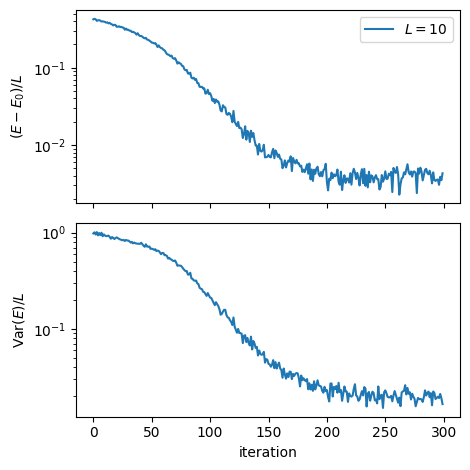

In [9]:
res = np.array(res)

fig, ax = plt.subplots(2,1, sharex=True, figsize=[4.8,4.8])
ax[0].semilogy(res[:, 0], res[:, 1] - exact_energy, '-', label=r"$L="+str(L)+"$")
ax[0].set_ylabel(r'$(E-E_0)/L$')

ax[1].semilogy(res[:, 0], res[:, 2], '-')
ax[1].set_ylabel(r'Var$(E)/L$')
ax[0].legend()
plt.xlabel('iteration')
plt.tight_layout()
plt.savefig('gs_search.pdf')